In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']

from scipy.signal import savgol_filter, medfilt
from scipy.optimize import minimize

# import importlib
# importlib.reload(utils)

In [8]:
def load_sphere_data(sphere='sphere_20250103'):
    data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'

    file = f'{data_dir}/sphere_data/{sphere}_recon_all.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout['recon_data_all']
        bc = g['bc'][:]
        hist = g['hist_all'][:]
        fout.close()

    file = f'{data_dir}/sphere_data/sphere_combined_calibration.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout[f'calibration_{sphere}']
        eff_coefs = g['sig_efficiency_fit_params'][:]
        fout.close()

    return bc, hist, eff_coefs

In [141]:
from scipy.special import erf, erfc

def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def gaus(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

def gaus_normalized(x, mu, sigma):
    xx = np.linspace(0, 50000, 5000)
    func_val = gaus(xx, mu, sigma)
    norm = np.trapz(func_val, xx)

    x = np.asarray(x)
    if x.size == 1:
        return gaus(x, mu, sigma)[0] / norm
    else:
        return gaus(x, mu, sigma) / norm

def expo_gaus(x, mu, sigma, xi):
    lamb = 1 / xi
    return (lamb / 2) * np.exp((lamb/2) * (2*mu + lamb*sigma**2 - 2*x) ) * erfc((mu + lamb*sigma*sigma - x)/(np.sqrt(2)*sigma))

def expo_gaus_normalized(x, mu, sigma, xi):
    xx = np.linspace(0, 50000, 5000)
    func_val = expo_gaus(xx, mu, sigma, xi)
    norm = np.trapz(func_val, xx)

    x = np.asarray(x)
    if x.size == 1:
        return expo_gaus(x, mu, sigma, xi)[0] / norm
    else:
        return expo_gaus(x, mu, sigma, xi) / norm

def crystal_ball_rev(x, alpha, n, mu, sigma):
    # Modified from https://arxiv.org/pdf/1603.08591
    # and https://en.wikipedia.org/wiki/Crystal_Ball_function

    x = np.asarray(x)
    ret = np.empty_like(x)

    A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
    B = n / np.abs(alpha) - np.abs(alpha)

    # Flip the direction to get the tail on the positive side
    idx_gaus = ((x - mu) / sigma) < alpha
    idx_other = ((x - mu) / sigma) > alpha

    # Flip `B - ...` to `B + ...` to reverse the power law tail 
    ret[idx_gaus] = np.exp(-1 * (x[idx_gaus] - mu)**2 / (2 * sigma**2))
    ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))

    return ret

def crystal_ball_rev_normalized(x, alpha, n, mu, sigma):
    xx = np.linspace(0, 50000, 5000)
    func_val = crystal_ball_rev(xx, alpha, n, mu, sigma)
    norm = np.trapz(func_val, xx)

    x = np.asarray(x)
    if x.size == 1:
        return crystal_ball_rev(x, alpha, n, mu, sigma)[0] / norm
    else:
        return crystal_ball_rev(x, alpha, n, mu, sigma) / norm

def expo_corrected(x, cutoff, xi):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 5000)

    expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < cutoff] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    ret = np.exp(-1 * (x) / xi) / xi
    ret[x < cutoff] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm

In [160]:
def get_mui(a, mu, sigma, mu_b, sigma_b, xi_b, bi, ntot):
    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = a * gaus_normalized(bi, mu, sigma) + (1 - a) * expo_gaus_normalized(bi, mu_b, sigma_b, xi_b)
    mui = ntot * joint_pdf * 50

    return mui

def nll(a, mu, sigma, mu_b, sigma_b, xi_b, bc, hist):
    idx = bc > 1000
    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    mui = get_mui(a, mu, sigma, mu_b, sigma_b, xi_b, bi, ntot)
    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [213]:
def plot_likelihood_fit(bc, hist, res_x, fig=None, ax0=None, ax1=None):
    if fig is None:
        fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])
        ax0 = axes[0]
        ax1 = axes[1]

    ana_threshold = 1000

    idx = bc > ana_threshold
    bi = bc[idx]
    ntot = np.sum(hist)

    hist_fit_ml = get_mui(*res_x, bi, ntot)
    a, mu, sigma, mu_b, sigma_b, xi_b = res_x

    ax = ax0
    ax.fill_betweenx(np.logspace(-1, 10, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.errorbar(bc, hist, yerr=np.sqrt(hist), fmt='.', color='#005AB5', alpha=1)
    ax.plot(bi, hist_fit_ml, '--', color='#DC143C', label='Maximum likelihood fit')

    xx0 = np.linspace(1020, 10000, 500)
    gaus_hist = ntot * 50 * a * gaus_normalized(xx0, mu, sigma)
    ax.fill_between(xx0, 0, gaus_hist, color='#E1BE6A', alpha=0.25)

    expo_gaus_hist = ntot * 50 * (1-a) * expo_gaus_normalized(xx0, mu_b, sigma_b, xi_b)
    ax.fill_between(xx0, 0, expo_gaus_hist, color='#2E8B57', alpha=0.1)

    ax.set_yscale('log')
    ax.set_xlim(0, 6000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 10, 12))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = ax1
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5)
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 6000)
    ax.set_ylim(-10, 10)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Res. ($\sigma_{\mathrm{stat}}$)')

    fig.tight_layout()

    return fig, ax0, ax1

In [175]:
bc_0, hist_0, eff_params_0 = load_sphere_data('sphere_20241202')
bc_1, hist_1, eff_params_1 = load_sphere_data('sphere_20250103')

In [211]:
args_0 = (bc_0, hist_0)
res_0 = minimize(fun=lambda x: nll(*x, *args_0), 
               method='Nelder-Mead',
               x0 = [0.9998, 170, 200, 0, 512, 120],
               bounds = [(0.999, 1), (0, 300), (100, 300), (0, 2000), (100, 1000), (0, 1000)],
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

args_1 = (bc_1, hist_1)
res_1 = minimize(fun=lambda x: nll(*x, *args_1), 
               method='Nelder-Mead',
               x0 = [0.999999, 205, 210, 1135, 34, 126],
               bounds = [(0.999, 1), (0, 500), (100, 300), (0, 2000), (0, 1000), (0, 1000)],
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

/tmp/tmp.pgrqlRcdT2/ipykernel_847519/1178749365.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))
/tmp/tmp.pgrqlRcdT2/ipykernel_847519/1178749365.py:20: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


Optimization terminated successfully.
         Current function value: -6585978.049596
         Iterations: 477
         Function evaluations: 872
Optimization terminated successfully.
         Current function value: -35004881.762235
         Iterations: 542
         Function evaluations: 961


/tmp/tmp.pgrqlRcdT2/ipykernel_847519/970968345.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.pgrqlRcdT2/ipykernel_847519/970968345.py:44: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5)


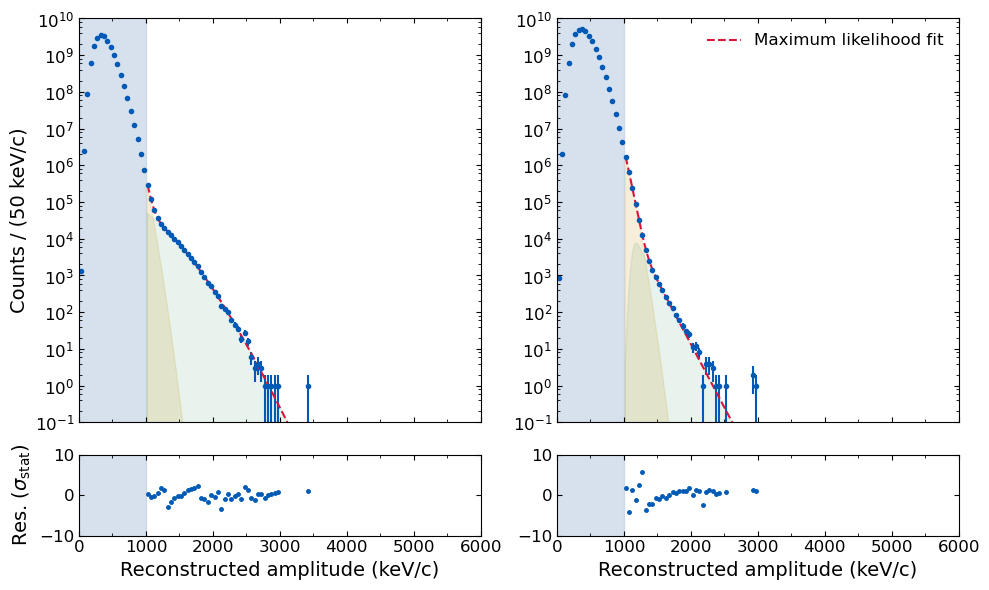

In [214]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), height_ratios=[5, 1])

fig, ax0, ax1 = plot_likelihood_fit(bc_0, hist_0, res_0.x, fig, axes[0, 0], axes[1, 0])
fig, ax2, ax3 = plot_likelihood_fit(bc_1, hist_1, res_1.x, fig, axes[0, 1], axes[1, 1])

ax0.legend().set_visible(False)
ax2.set_ylabel('')
ax3.set_ylabel('')
fig.tight_layout()